<h1>QCut QAOA demo on a noisy simulator</h1>

In this notebook we present demo of how to use QAOA to solve the max-cut problem with QCut. Here we use the IQMFakeAdonis backend that models the noise of the Helmi quantum computer that is a part of the Finnish Quantum Computing Infrastructure (FiQCI) HPC+QC framwork.

QAOA is a quantum approximation algorithm for solving combinatorial problems by optimizing some circuit parameters to obtain a minimum value for a problem-specific cost function. The objective of the Max_Cut problem is to find a way to partition a graph into two separate subgraphs by cutting as many vertices as possible. It has applications for example in machine learning, circuit design and statistical physics. For more comprehensive introduction to QAOA and the Max-Cut problem refer to <a href="https://github.com/FiQCI/fiqci-examples/blob/main/Course%20Material/Introduction%20to%20Quantum%20Computing%20and%20FiQCI/Exercises/05%20QAOA.ipynb">FiQCI QAOA tutorial</a>.

<h2>Before proceeding</h2>

Make sure to have installed all of the required packages. For this notebook you need to do:

```python
pip install QCut
pip install qiskit-iqm
pip install openQAOA
pip install pylatexenc
```

Everything else is installed as a dependency.

<h2>First we import needed packages</h2>



In [1]:
import os

import numpy as np
import networkx as nx
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import PauliList

from iqm.qiskit_iqm import IQMFakeAdonis

from QCut import cut_wire
from QCut import wirecut as ck
from QCut.backend_utility import transpile_experiments, run_and_expectation_value

from openqaoa.problems import MaximumCut
from openqaoa.utilities import ground_state_hamiltonian
from openqaoa.qaoa_components import Hamiltonian

<h2>Define the problem graph</h2>

Using the networx package we can define a list of edges and use them to inititalize a problem graph.

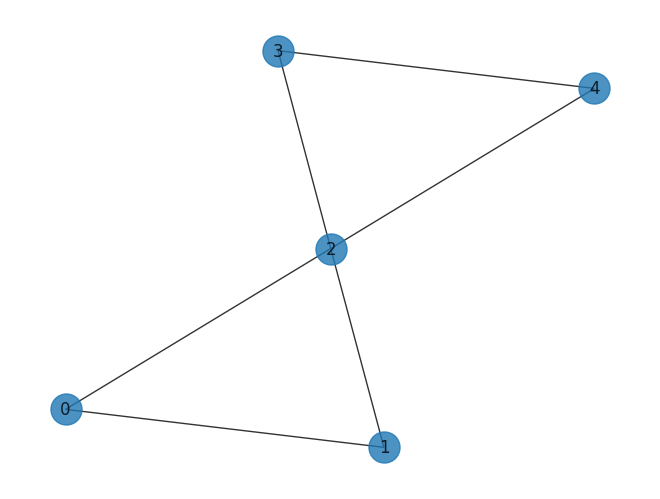

In [2]:
edges = [(0,1), (1,2), (2,0), (2,3), (2,4), (3,4)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

<h2>Get information for Max-Cut</h2>

Using the openQAOA package we can get the Max-Cut Hamiltonian and the solution minimum energy and states for the Max-Cut problem for our graph.

In [3]:
maxcutProb = MaximumCut(G)
maxcutQUBO = maxcutProb.qubo

hamiltonian = maxcutQUBO.hamiltonian.expression

groundState = ground_state_hamiltonian(maxcutQUBO.hamiltonian)

<h2>Process Hamiltonian</h2>

Define a helper function to transform the Hamiltonian into a more convenient form.

In [4]:
def hamiltonian_to_strings(hamiltonian: Hamiltonian, length: int) -> dict:
    """Convert openQAOA hamiltonian to a convenient form."""
    terms = str(hamiltonian).split("+")
    new_strings = []
    coefs = []
    const = 0

    for term in terms:
        indices = [int(i.strip("_{ }")) for i in term.split("Z")[1:]]

        new_string = "I"*length

        if len(indices) != 0:
            coefs.append(float(term[:4]))
            list_string = list(new_string)

            for i in indices:
                list_string[i] = "Z"

            new_strings.append("".join(list_string)[::-1])

        else:
            const += float(term[:4])

    return {"paulis":PauliList(new_strings), "coefs": coefs, "const": const}

<h2>Reformat the Hamiltonian</h2>

Use the defined function to transform the Hamiltonian. Additionally define the nqubits variable for storing the number of qubits we will have in our QAOA circuit.

In [5]:
nqubits = len(G.nodes())
print(hamiltonian)
reformattedHamiltonian = hamiltonian_to_strings(hamiltonian, nqubits)
reformattedHamiltonian

0 + 1.0Z_{0}Z_{1} + 1.0Z_{0}Z_{2} + 1.0Z_{1}Z_{2} + 1.0Z_{2}Z_{3} + 1.0Z_{2}Z_{4} + 1.0Z_{3}Z_{4}


{'paulis': PauliList(['IIIZZ', 'IIZIZ', 'IIZZI', 'IZZII', 'ZIZII', 'ZZIII']),
 'coefs': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'const': 0.0}

<h2>Functions to generate QAOA circuit</h2>

Define functions to generate QAOA circuit both for the uncut and wire-cutting cases.

In [6]:
def create_cut_qaoa_circ(theta):
    n_layers = len(theta)//2 # number of alternating unitaries
    beta = theta[:n_layers] #newest beta
    gamma = theta[n_layers:] #newest gamma
    #create actual circuit object
    qc_cut = QuantumCircuit(nqubits+1)
    #entagling layer
    for i in range(3):
        qc_cut.h(i)
    for i in range(4,nqubits+1):
        qc_cut.h(i)
    for layer_index in range(n_layers):
        #cost layer
        if layer_index % 2 == 0:
            qc_cut.rzz(2*gamma[layer_index], 0,1)
            qc_cut.rzz(2*gamma[layer_index], 0,2)
            qc_cut.rzz(2*gamma[layer_index], 1,2)
            qc_cut.append(cut_wire, [2,3]) #cut
            qc_cut.rzz(2*gamma[layer_index],3,4)
            qc_cut.rzz(2*gamma[layer_index],3,5)
            qc_cut.rzz(2*gamma[layer_index],4,5)
            for i in range(2):
                qc_cut.rx(2*beta[layer_index], i)
            for i in range(3, nqubits+1):
                qc_cut.rx(2*beta[layer_index], i)
        else:
            qc_cut.rzz(2*gamma[layer_index],4,5)
            qc_cut.rzz(2*gamma[layer_index],3,5)
            qc_cut.rzz(2*gamma[layer_index],3,4)
            qc_cut.append(cut_wire, [3,2]) #cut
            qc_cut.rzz(2*gamma[layer_index], 1,2)
            qc_cut.rzz(2*gamma[layer_index], 0,2)
            qc_cut.rzz(2*gamma[layer_index], 0,1)
            for i in range(3):
                qc_cut.rx(2*beta[layer_index], i)
            for i in range(4, nqubits+1):
                qc_cut.rx(2*beta[layer_index], i)
        #mixing layer
    return qc_cut

def create_qaoa_circ(theta):
    n_layers = len(theta)//2 # number of alternating unitaries
    beta = theta[:n_layers] #newest beta
    gamma = theta[n_layers:] #newest gamma
    #create actual circuit object
    qc = QuantumCircuit(nqubits)
    #entagling layer
    for i in range(nqubits):
        qc.h(i)
    for layer_index in range(n_layers):
        #cost layer
        for i,j in G.edges():
            qc.rzz(2*gamma[layer_index], i, j)
        #mixing layer
        for i in range(nqubits):
            qc.rx(2*beta[layer_index], i)
    qc.measure_all()
    return qc

<h2>Create the uncut QAOA circuit</h2>

c:\Users\nivalajo\AppData\Local\miniconda3\envs\QCut\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


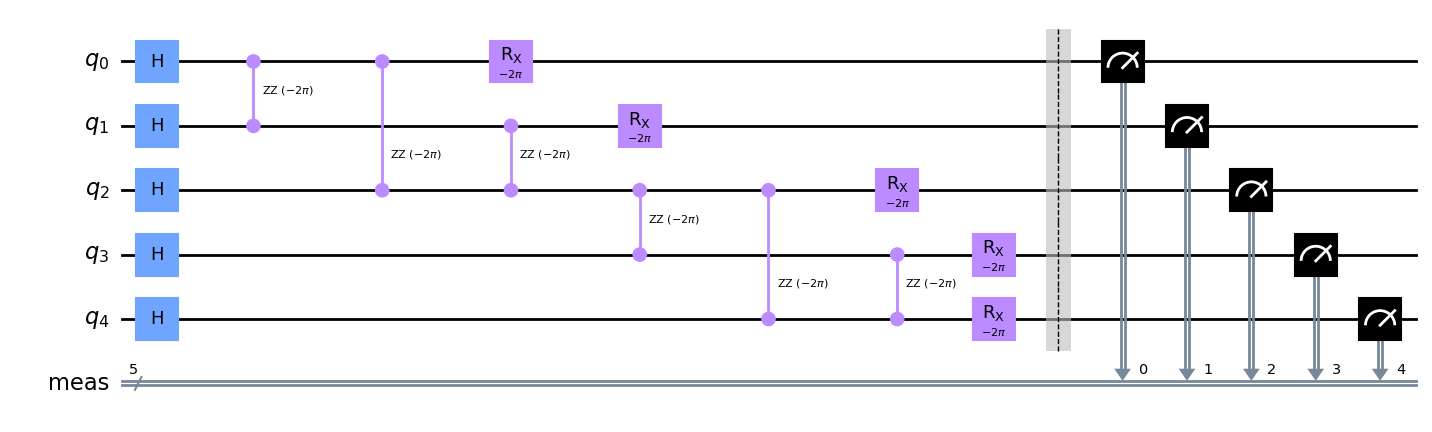

In [7]:
qc = create_qaoa_circ([-np.pi, -np.pi])

qc.draw("mpl")

<h2>Create the wire-cut QAOA circuit</h2>

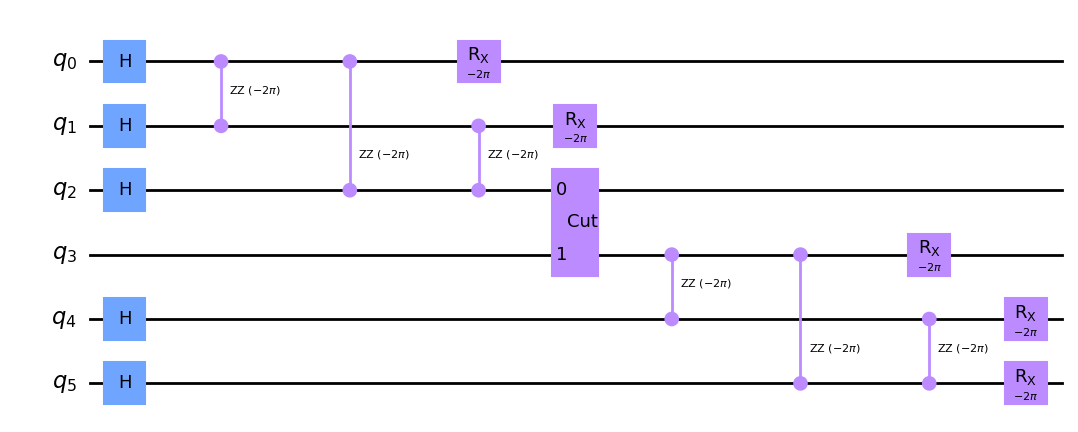

In [8]:
qca = create_cut_qaoa_circ([-np.pi, -np.pi])
qca.draw("mpl")

<h2>Define functions to calculate the Hamiltoninan expectation values for bot uncut and wire-cut cases</h2>

In [9]:
def get_expectation_cut(hamiltonian, backend):
    exps_cut = np.empty(0) #store expectation value from each optimization step
    #execute circuit and calculate expectation value
    def execute_circ(theta):
        qca = create_cut_qaoa_circ(theta) #create circuit with current
        
        qss, circs = ck.get_locations_and_subcircuits(qca)
        #make the experiment circuits
        allcircs, coefs, id_meas = ck.get_experiment_circuits(circs, qss)
        transpiledExperiments = transpile_experiments(allcircs, backend)
        #run the experiments, apply the {0,1} -> [-1,1] post-processing function
        results = ck.run_experiments(transpiledExperiments, qss, id_meas, shots=2**12, backend=backend)

        #modres = nck.processResults(results)

        #sample the experiment results and calculate the expectation value
        #['IIIZZ', 'IIZIZ', 'IIZZI', 'IZZII', 'ZIZII', 'ZZIII']
        reconstructed_expvals = ck.estimate_expectation_values(results, coefs, qss, observables=edges)

        #Calculate the hamiltonian expectation value
        f = hamiltonian["const"]
        for i, j in zip(reconstructed_expvals, hamiltonian["coefs"]):
            f += i*j
        global exps_cut
        exps_cut =np.append(exps_cut, f)
        return f
    return execute_circ, exps_cut

def get_expectation_backend(hamiltonian, backend):
    exps_uncut = np.empty(0)
    def execute_circ(theta):
        qc = create_qaoa_circ(theta)
        circuit = transpile(qc, backend, optimization_level=3)
        counts, exact_expvals = run_and_expectation_value(circuit, backend, edges, 2**12, mitigate = False)
        f = hamiltonian["const"]
        for i, j in zip(exact_expvals, hamiltonian["coefs"]):
            f += i*j
        global exps_uncut
        exps_uncut = np.append(exps_uncut, f)
        return f
    return execute_circ, exps_uncut


<h2>Run QAOA</h2>

Run QAOA for both uncut and wire-cut cases. We use the scipy.minimize() CABYLA method for finding the circuit parameters that minimize the Hamiltonian expectation value.

In [19]:
backend = IQMFakeAdonis()
sim = AerSimulator()
expectation, exps_cut = get_expectation_cut(reformattedHamiltonian, backend=sim)
initial_params = [-np.pi, -np.pi]
#minimize cut qaoa cost using COBYLA
res_cut = minimize(expectation,
                initial_params,
                method='COBYLA',
                options={'maxiter': 40},
                )
res_cut

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.857277512550339
       x: [-1.902e+00 -2.856e+00]
    nfev: 33
   maxcv: 0.0

In [22]:
expectation, exps_uncut = get_expectation_backend(reformattedHamiltonian, backend=sim)
#minimize uncut qaoa cost using COBYLA
res_uncut = minimize(expectation,
                initial_params,
                method='COBYLA',
                options={'maxiter': 100}
                )
res_uncut

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.84765625
       x: [-1.882e+00 -2.867e+00]
    nfev: 36
   maxcv: 0.0

<h2>Plot results</h2>

Plot the cost function from both cases.

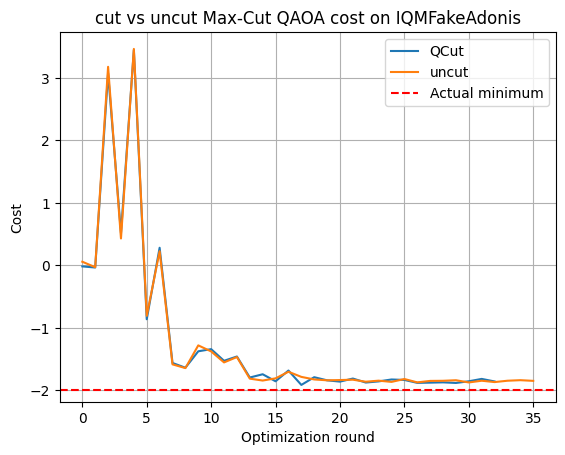

In [23]:
x = range(len(exps_cut))
x1 = range(len(exps_uncut))
plt.plot(x, exps_cut, label='QCut')
plt.plot(x1, exps_uncut, label='uncut')
plt.axhline(y=groundState[0], color='r', linestyle='--', label = 'Actual minimum')
plt.xlabel('Optimization round')
plt.ylabel('Cost')
plt.title('cut vs uncut Max-Cut QAOA cost on IQMFakeAdonis')
plt.legend()
plt.grid(True)

<h2>Get solution states</h2>

Use the found optimal parameters from the wire-cut QAOA toplot the obtained solution states.

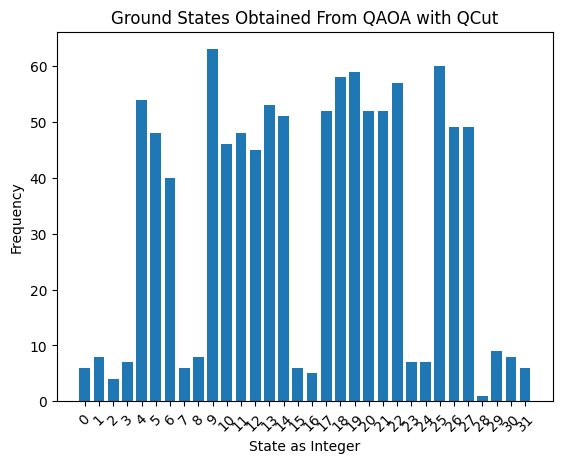

In [24]:
qc_res = create_qaoa_circ(res_cut.x)
result = backend.run(qc_res).result()
counts = result.get_counts()
keys = list(sorted([int(k[::-1], 2) for k in counts.keys()]))
values = [counts.get(k, 0) for k in sorted(counts.keys())]
plt.bar([i*2 for i in range(len(keys))], values, width=1.5)
plt.xticks([i*2 for i in range(len(keys))], keys, rotation=45)
plt.xlabel('State as Integer')
plt.ylabel('Frequency')
plt.title('Ground States Obtained From QAOA with QCut')
plt.grid(False)

In [29]:
QAOA_solutions = sorted(x[0] for x in sorted(zip(keys, values), key= lambda x: x[1], reverse=True)[:len(groundState[1])])
ideal_solutions = sorted([int(k,2) for k in groundState[1]])

Now we can check that the most likely outcomes match the ideal solution states.

In [30]:
print(f"QAOA solution: {QAOA_solutions}")
print(f"Ideal solutions: {ideal_solutions}")
print(f"All results match: {np.array_equal(QAOA_solutions, ideal_solutions)}")

QAOA solution: [4, 5, 6, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 25, 26, 27]
Ideal solutions: [4, 5, 6, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 25, 26, 27]
All results match: True
